# Week 15: Edge Smoothing

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from scipy.spatial import Delaunay
from scipy.optimize import minimize

from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_adjacent_vertices_with_boundary_vertex, retrieve_adjacent_vertices_with_vertex, retrieve_boundary_edges_related_vertices_2D
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_boundary_vertices
from util.util import distance_euclidean

from util.pyvista_util import preprocess, postprocess

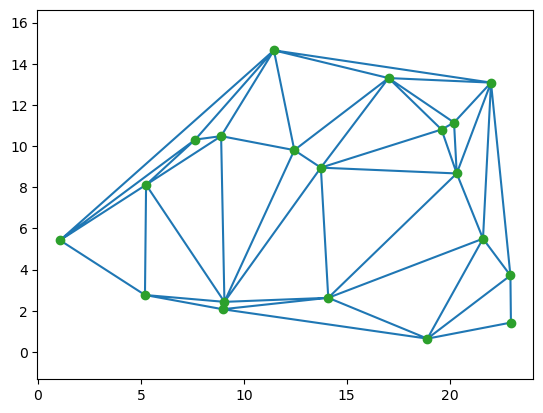

In [3]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=23
points[:, 1]*=15

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

vertices = points.copy()
faces = tri.simplices

In [139]:
class boundary_smoothing_tutte:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
        self.angle = np.zeros(self.BV_num)
    
    def activation(self, angle):
        if angle < (np.pi/4):
            return np.power(np.cos(2*angle), 2) / angle + 1
        else:
            return np.power(np.sin(2*angle), 2)
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E_angle = 0
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
#             self.angle.append(angle)
            E_angle += self.activation(angle)

        return E_angle
    
    def get_angle(self):
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = self.solution[self.BV_r_V][v1] - self.solution[self.BV_r_V][i]
            edge2 = self.solution[self.BV_r_V][v2] - self.solution[self.BV_r_V][i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            self.angle[i]=angle
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(self.vertices, self.faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [93]:
test = boundary_smoothing_tutte(vertices, faces)

In [94]:
# for i, (v1, v2) in enumerate(test.BV_r_BV):
#     for edge in test.BE_r_V:
#         plt.plot(test.solution[np.array(edge), 0], test.solution[np.array(edge), 1], 'b-')
#     plt.plot(test.solution[test.BV_r_V][i][0], test.solution[test.BV_r_V][i][1], 'o')
#     plt.plot(test.solution[test.BV_r_V][v1][0], test.solution[test.BV_r_V][v1][1], 'o')
#     plt.plot(test.solution[test.BV_r_V][v2][0], test.solution[test.BV_r_V][v2][1], 'o')
#     ttt1 = np.vstack([test.solution[test.BV_r_V][v1], test.solution[test.BV_r_V][i]]).T
#     ttt2 = np.vstack([test.solution[test.BV_r_V][v2], test.solution[test.BV_r_V][i]]).T
#     plt.plot(ttt1[0], ttt1[1], 'r-')
#     plt.plot(ttt2[0], ttt2[1], 'r-')
    
#     plt.show()

In [95]:
test.optimize_default()

In [96]:
test.get_angle()

In [97]:
test.mapping()

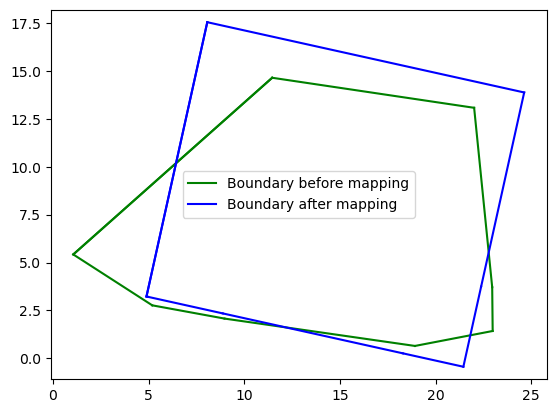

In [98]:
test.v_plt(show_origin=True, show_BV=False, show_vertices=False, show_inner_edges=False)

In [15]:
tritess_v, tritess_f = preprocess("./mesh/tritess/tritess_input.ply")
tritess_test = boundary_smoothing_tutte(tritess_v, tritess_f)

In [16]:
tritess_test.optimize_default()

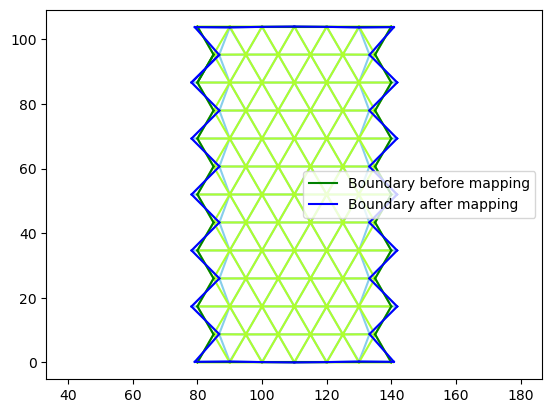

In [17]:
tritess_test.v_plt(show_origin=True, show_BV=False, show_vertices=False, show_inner_edges=True)

In [111]:
cat_v, cat_f = preprocess("./mesh/horse/horse_input.ply")
cat_test = boundary_smoothing_tutte(cat_v, cat_f)

In [112]:
v, f = preprocess("./mesh/horse/smooth/horse_output.ply")
cat_test2 = boundary_smoothing_tutte(v, f)

In [115]:
cat_test2.get_angle()
cat_test.get_angle()

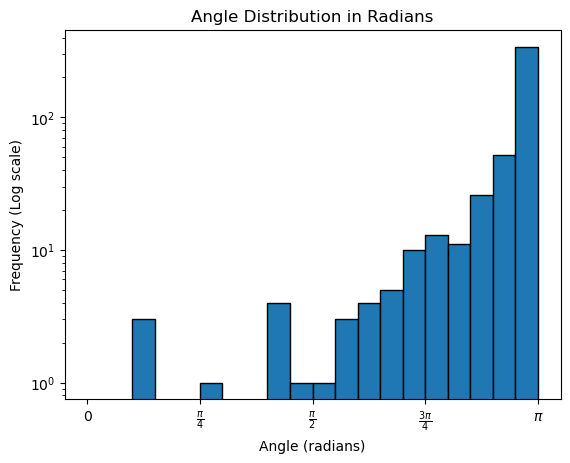

In [122]:
plt.hist(cat_test.angle, bins=20, range=(0, np.pi), edgecolor='black')
plt.title('Angle Distribution in Radians')
plt.xlabel('Angle (radians)')
plt.ylabel('Frequency (Log scale)')
plt.xticks(np.linspace(0, np.pi, 5), ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])

# 设置y轴为对数刻度
plt.yscale('log')
plt.savefig('./mesh/horse/smooth/before.png')
plt.show()

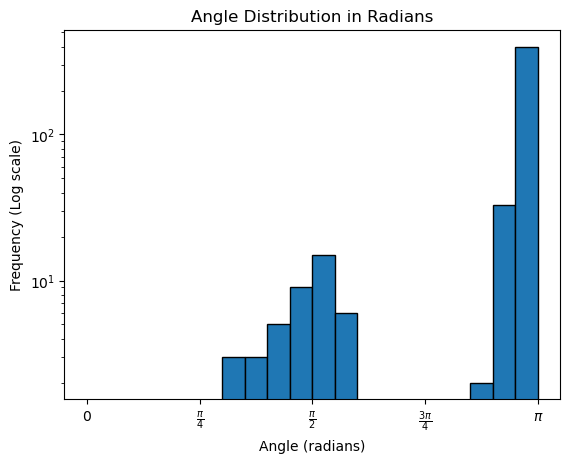

In [121]:
plt.hist(cat_test2.angle, bins=20, range=(0, np.pi), edgecolor='black')
plt.title('Angle Distribution in Radians')
plt.xlabel('Angle (radians)')
plt.ylabel('Frequency (Log scale)')
plt.xticks(np.linspace(0, np.pi, 5), ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])

# 设置y轴为对数刻度
plt.yscale('log')
plt.savefig('./mesh/horse/smooth/after.png')
plt.show()

In [101]:
postprocess("./mesh/cat/smooth/30.ply", cat_test2.solution, cat_test2.faces)

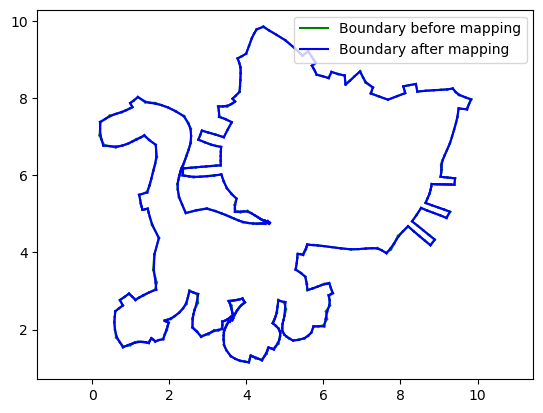

In [60]:
cat_test2.v_plt(show_origin=True, 
               show_BV=False, 
               show_vertices=False, 
               show_inner_edges=False, 
#                save_dict='./mesh/cat/smooth/30.png'
              )

# =============================================================

In [24]:
cat_v, cat_f = preprocess("./mesh/horse/horse_input.ply")
cat_test = boundary_smoothing_tutte(cat_v, cat_f)

In [25]:
# cat_test.optimize(30)

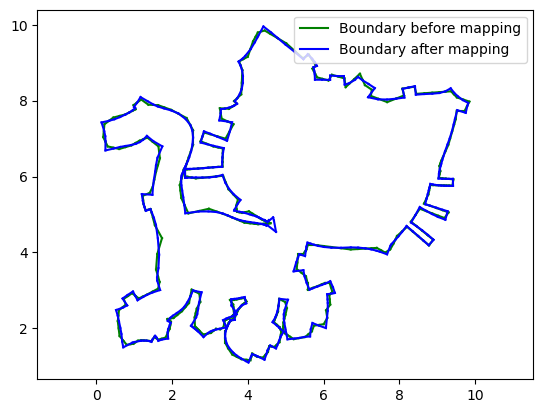

In [28]:
cat_test.v_plt(show_origin=True, 
               show_BV=False, 
               show_vertices=False, 
               show_inner_edges=False, 
#                save_dict='./mesh/cat/smooth/30.png'
              )

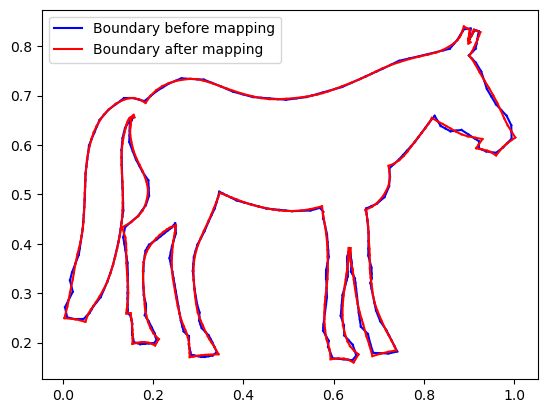

In [134]:

for edge in cat_test.BE_r_V:
    plt.plot(cat_test.solution[np.array(edge), 0], cat_test.solution[np.array(edge), 1], 'b-')
plt.plot(cat_test.solution[np.array(cat_test.BE_r_V[0]), 0], cat_test.solution[np.array(cat_test.BE_r_V[0]), 1], label='Boundary before mapping', color='blue')
for edge in cat_test2.BE_r_V:
    plt.plot(cat_test2.vertices[np.array(edge), 0], cat_test2.vertices[np.array(edge), 1], 'r-')
plt.plot(cat_test2.vertices[np.array(cat_test2.BE_r_V[0]), 0], cat_test2.vertices[np.array(cat_test2.BE_r_V[0]), 1],label='Boundary after mapping', color='red')
# plt.xlim(4.5, 6.5)
# plt.ylim(1.5, 3.5)
# plt.axis('equal')
plt.legend()
plt.savefig('./mesh/horse/smooth/compare.png')

plt.show()

In [31]:
postprocess("./mesh/cat/cat_output_smoothing_2.ply", cat_test.solution, cat_test.faces)

In [35]:
cat_test.optimize_default()

In [1]:
cat_test.v_plt(show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False)

NameError: name 'cat_test' is not defined

In [40]:
postprocess("./mesh/cat/cat_output_perfect2.ply", cat_test.solution, cat_test.faces)

In [ ]:
cat_test.optimize_default()

# ============================================================

In [148]:
cat_v, cat_f = preprocess("./mesh/ring/ring_output.ply")
ring_test = boundary_smoothing_tutte(cat_v, cat_f)

In [149]:
v, f = preprocess("./mesh/ring/ring_input.ply")
cat_test = boundary_smoothing_tutte(v, f)

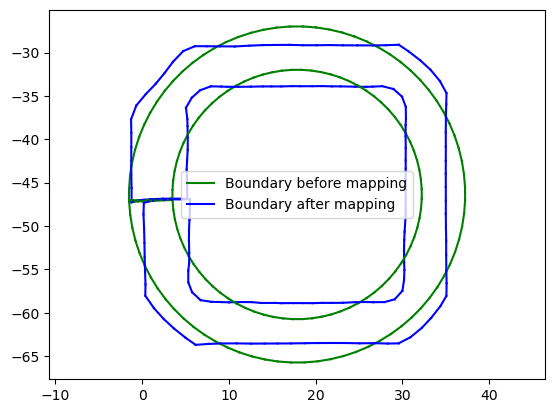

In [151]:
# plt.triplot(poly.solution[:,0], poly.solution[:,1], faces)
for edge in cat_test.BE_r_V:
    plt.plot(cat_test.vertices[np.array(edge), 0], cat_test.vertices[np.array(edge), 1], 'g-')
    plt.plot(ring_test.solution[np.array(edge), 0], ring_test.solution[np.array(edge), 1], 'b-')
plt.plot(cat_test.vertices[np.array(ring_test.BE_r_V[0]), 0], cat_test.vertices[np.array(ring_test.BE_r_V[0]), 1], label='Boundary before mapping', color='green')
plt.plot(ring_test.solution[np.array(ring_test.BE_r_V[0]), 0], ring_test.solution[np.array(ring_test.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')


# plt.triplot(cat_test.vertices[:,0], cat_test.vertices[:,1], cat_test.faces, color='greenyellow')
# plt.triplot(ring_test.solution[:,0], ring_test.solution[:,1], ring_test.faces, color='lightskyblue')

plt.axis('equal')
plt.legend()
# plt.xlim(3,8)
# plt.ylim(-38,-33)
plt.savefig('./mesh/ring/best', dpi=300)
plt.show()